
# APPLICATION OF APACHE SPARK AND LSTM IN BANANA PRICE PREDICTION

# The dataset

The dataset was obtained from the data.gov.ie website. Two datasets on National average of consumer Items on Ireland. 
One dataset was ranging from 2002 to 2011
the other was ranging from 2011 to 2024 February. Below is the link to the datasets
https://data.gov.ie/dataset/cpm12-national-average-price
https://data.gov.ie/dataset/cpm04-national-average-price
    
Both datasets licence are under the creative  commons licence https://creativecommons.org/licenses/by/4.0/
which states as below
You are free to:
Share — copy and redistribute the material in any medium or format for any purpose, even commercially.
Adapt — remix, transform, and build upon the material for any purpose, even commercially.
The licensor cannot revoke these freedoms as long as you follow the license terms.

## STOP ANY ACTIVE SPARK SESSION

In [1]:
from pyspark.sql import SparkSession

# Stop all active Spark sessions
SparkSession.builder.getOrCreate().stop()


## Import all the necessary libraries required for loading the data, EDA, Data Cleaning and statistics

In [2]:
import warnings
warnings.filterwarnings("ignore")
from pyspark.ml import Pipeline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#List the contents of the root directory in HDFS
!hdfs dfs -ls /

Found 5 items
-rwxrwxrwx   1 hduser supergroup    1114475 2024-03-31 17:22 /CPM04.20240331170654.csv
-rwxrwxrwx   1 hduser supergroup    1197604 2024-03-31 17:23 /CPM12.20240331170619.csv
drwxr-xr-x   - hduser supergroup          0 2024-01-30 23:49 /output1
drwxr-xr-x   - hduser supergroup          0 2024-04-02 16:40 /preprocessed_data.csv
drwxr-xr-x   - hduser supergroup          0 2024-01-31 00:57 /user1


## Preprocessing Data using Spark
This process involves a series of steps. They include:-
1. Loading 2 CSV files on national average prices of food data stored in hadoop.

2. Data Exploration: Perform exploratory data analysis (EDA) 

This include:-
- checking missing data, 
- Checking for duplicates
- Checking for oultiers
- Checking for data types.
- visualize data to see data pattern

3. Data cleaning and preparation: 
- merging the two csv datasets
- handling duplicates, missing data, outliers, 
- feature selection, 
- changing data types

## Initialize Spark Session

In [4]:
#A spark sesion for the preprocessing
spark = SparkSession.builder \
    .appName("Hadoop to python- using apache spark") \
    .getOrCreate()

## Step one: Load the data from hadoop using spark
The two datasets were stored in hadoop and therefore the had to be loaded on pyspark for processing

In [5]:
#Hadoop path for the two datasets
dataset_one = "hdfs://localhost:9000/CPM04.20240331170654.csv"
dataset_two = "hdfs://localhost:9000/CPM12.20240331170619.csv"

#Create spark DataFrames for the two datasets
df_one = spark.read.csv(dataset_one, header=True, inferSchema=True)
df_two = spark.read.csv(dataset_two, header=True, inferSchema=True)

#View the two DataFRames
df_one, df_two

(DataFrame[STATISTIC: string, Statistic Label: string, C02363V02844: int, Consumer Item: string, TLIST(M1): int, Month: string, UNIT: string, VALUE: double],
 DataFrame[STATISTIC: string, STATISTIC Label: string, TLIST(M1): int, Month: string, C02363V03422: int, Consumer Item: string, UNIT: string, VALUE: double])

## Step Two: Performing Explorartory Data Analysis (EDA)
- EDA involves viewing the first and last few observations and the last.
- Checking data types present and variables 
- Checking for missing data
- Checking for outliers
- checking for duplicates
- Visualization

## i) View the first view observations of the DataFrames

In [6]:
#View the first two observations of DataFrame one
df_one.head(2)

[Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=10010, Consumer Item='Round steak per kg.', TLIST(M1)=200112, Month='2001M12', UNIT='Euro', VALUE=8.414),
 Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=10010, Consumer Item='Round steak per kg.', TLIST(M1)=200201, Month='2002M01', UNIT='Euro', VALUE=8.696)]

In [7]:
#View the first two observations fo DataFrame two 
df_two.head(2)

[Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=201112, Month='2011 December', C02363V03422=10020, Consumer Item='White, self raising flour per 2 kg', UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=201112, Month='2011 December', C02363V03422=10030, Consumer Item='Brown, wholemeal flour per 2 kg', UNIT='Euro', VALUE=None)]

## ii) View the last few observations of the DataFrames

In [8]:
#View the last two observations of DataFrame one
df_one.tail(2)

[Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=80005, Consumer Item='Fine quality wine - take home (75cl bottle)', TLIST(M1)=201111, Month='2011M11', UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=80005, Consumer Item='Fine quality wine - take home (75cl bottle)', TLIST(M1)=201112, Month='2011M12', UNIT='Euro', VALUE=None)]

In [9]:
#View the last two observations of DataFrame two
df_two.tail(2)

[Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=202402, Month='2024 February', C02363V03422=30700, Consumer Item="Gent's wash, cut, and blow dry fee", UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=202402, Month='2024 February', C02363V03422=30720, Consumer Item="Ladies' wash, cut and blow dry fee", UNIT='Euro', VALUE=53.175)]

## iii) Checking for missing data and  data types in the DataFrames

In [10]:
#Get the Schema for DataFrame one
df_one.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- C02363V02844: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- Shows there is missing data (nullable =True) in all the variables
- we have several data types, string, integer, double
- month which is the time variable is a string

In [11]:
#Get the Schema for DataFrame two
df_two.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- STATISTIC Label: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- C02363V03422: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- Shows there is missing data (nullable =True) in all the variables
- we have several data types, string, integer, double
- month which is a time variable is a string

In [12]:
#Check the chacteristics of the DataFrames
df_one.describe(), df_two.describe()

(DataFrame[summary: string, STATISTIC: string, Statistic Label: string, C02363V02844: string, Consumer Item: string, TLIST(M1): string, Month: string, UNIT: string, VALUE: string],
 DataFrame[summary: string, STATISTIC: string, STATISTIC Label: string, TLIST(M1): string, Month: string, C02363V03422: string, Consumer Item: string, UNIT: string, VALUE: string])

## iv) Check the Size of the DataFrames to ensure there is no high dimensionality

In [13]:
#Count the number of observations
dataone_count = df_one.count()

print("Number of observations:", dataone_count)

Number of observations: 10527


## Findings
- The observations are more than the variables, hence data is a low dimension data

In [14]:
#Count the number of observations
datatwo_count = df_two.count()

print("Number of observations:", datatwo_count)

Number of observations: 11172


## Findings
- The observations are more than the variables, hence data is a low dimension data

## v) Checking for outliers

In [15]:
#compute outlier bounds using the IQR method for the VALUE variable in the df_one DataFrame.

cols = ['VALUE']
bounds = {}

for col in cols:
    quantiles = df_one.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds

#creates a DataFrame outliers_one that flags outliers in df_one based on the outlier bounds calculated using the IQR method above.
outliers_one = df_one.select(*['Month','Consumer Item'] + [
    (
        (df_one[c] < bounds[c][0]) | 
        (df_one[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_one.show()

#Count the frequency of outliers in df_one
outliers_one.groupby('VALUE_o').count().show()

+-------+-------------------+-------+
|  Month|      Consumer Item|VALUE_o|
+-------+-------------------+-------+
|2001M12|Round steak per kg.|  false|
|2002M01|Round steak per kg.|  false|
|2002M02|Round steak per kg.|  false|
|2002M03|Round steak per kg.|  false|
|2002M04|Round steak per kg.|  false|
|2002M05|Round steak per kg.|  false|
|2002M06|Round steak per kg.|  false|
|2002M07|Round steak per kg.|  false|
|2002M08|Round steak per kg.|  false|
|2002M09|Round steak per kg.|  false|
|2002M10|Round steak per kg.|  false|
|2002M11|Round steak per kg.|  false|
|2002M12|Round steak per kg.|  false|
|2003M01|Round steak per kg.|  false|
|2003M02|Round steak per kg.|  false|
|2003M03|Round steak per kg.|  false|
|2003M04|Round steak per kg.|  false|
|2003M05|Round steak per kg.|  false|
|2003M06|Round steak per kg.|  false|
|2003M07|Round steak per kg.|  false|
+-------+-------------------+-------+
only showing top 20 rows

+-------+-----+
|VALUE_o|count|
+-------+-----+
|   null| 1047

## Findings
- there are 510 outliers in dataframe df_one
- there are 1047 null values

In [16]:
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['VALUE']
bounds = {}

for col in cols:
    quantiles = df_two.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in df_one based on the outlier bounds calculated using the IQR method above.
outliers_two = df_two.select(*['Month','Consumer Item'] + [
    (
        (df_two[c] < bounds[c][0]) | 
        (df_two[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_two.show()


#Count number of outliers in DataFrame df_two
outliers_two.groupby('VALUE_o').count().show()

+-------------+--------------------+-------+
|        Month|       Consumer Item|VALUE_o|
+-------------+--------------------+-------+
|2011 December|White, self raisi...|   null|
|2011 December|Brown, wholemeal ...|   null|
|2011 December|Bread, white slic...|   null|
|2011 December|Bread, brown slic...|   null|
|2011 December|  Spaghetti per 500g|   null|
|2011 December|Sirloin steak per kg|   null|
|2011 December|Striploin steak p...|   null|
|2011 December|Roast beef - tops...|   null|
|2011 December|Sliced / diced be...|   null|
|2011 December|Pork loin chops p...|   null|
|2011 December|   Pork steak per kg|   null|
|2011 December|Lamb - whole leg ...|   null|
|2011 December|Lamb loin chops p...|   null|
|2011 December|Lamb gigot chops ...|   null|
|2011 December|Uncooked chicken ...|   null|
|2011 December| Lamb's liver per kg|   null|
|2011 December|   Ham fillet per kg|   null|
|2011 December|   Cooked ham per kg|   null|
|2011 December|Best back rashers...|   null|
|2011 Dece

## Findings
- there are 618 outliers
- there are 1077 missing data 

## vi) Checking for Duplicates
- Checking duplicates based on three variables, month, consumer Item and VALUE
- Checking duplicates based on the whole data

In [17]:
#Drop duplicates based on Month, COnsumer Item and VALUE
duplicated_df = df_one.dropDuplicates(['Month', 'Consumer Item','VALUE'])

#count the number of duplicates
num_duplicates = df_one.count() - duplicated_df.count()

#Show the number of duplicates
print("Number of duplicates based on date:", num_duplicates)


Number of duplicates based on date: 0


## Findings
- There are no duplicates present

In [18]:
#Drop duplicates based on Month, COnsumer Item and VALUE
duplicated_df = df_two.dropDuplicates(['Month', 'Consumer Item','VALUE'])

#Count the number of duplicates
num_duplicates = df_two.count() - duplicated_df.count()

#show the number of duplicates
print("Number of duplicates based on date:", num_duplicates)

Number of duplicates based on date: 0


## Findings
- There are no duplicates present

In [19]:
#Count for duplicates in the whole df_one DataFrame
print('Count of rows: {0}'.format(df_one.count()))
print('Count of distinct rows: {0}'.format(df_one.distinct().count()))

Count of rows: 10527
Count of distinct rows: 10527


In [20]:
#Count the duplicates in the whole df_two DataFrame
print('Count of rows: {0}'.format(df_two.count()))
print('Count of distinct rows: {0}'.format(df_two.distinct().count()))

Count of rows: 11172
Count of distinct rows: 11172


# Step Three: Data Cleaning.
- Dropping missing data, duplicates
- Drop columns that will not be used.
- Drop observations that will not be used, by considering the Consumer Item.My aim is to predict the banana price so any other item is dropped.
- Convert the variable (month) to the correct data types which is date-time


## i) Delete variables that willnot be used

In [21]:
#Drop all columns except month, consumer item and VALUE) in df_one
df_one = df_one.drop("STATISTIC","STATISTIC Label","TLIST(M1)","UNIT","C02363V02844")

#Check if the colmuns have been dropped
df_one.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- The variables have been dropped

In [22]:
#Drop all columns except month, consumer item and VALUE) in df_two
df_two = df_two.drop("STATISTIC","STATISTIC Label","TLIST(M1)","UNIT","C02363V03422")


#Check if the columns have been dropped
df_two.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- The variables have been dropped

## ii) Drop from consumer Item, everything except bananas

In [23]:
#Drop all other consumer items from the consumer item except bananas per kg
df_one = df_one.filter(df_one["Consumer Item"] == "Bananas per kg.")
df_two = df_two.filter(df_two["Consumer Item"] == "Bananas per kg")

In [24]:
#Check if the items have been dropped
df_one.show(n=df_one.count(), truncate=False), df_two.show(n=df_two.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2001M12|1.685|
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas

(None, None)

## iii) Drop Missing data from the dataframes
- check which variables have missing data
- Drop the missing Data


In [25]:
#Checking for Missing data
df_one.printSchema(), df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

In [26]:
#Drop null values from df_one
df_one = df_one.na.drop(how='any', subset=["Consumer Item", "Month", "VALUE"],thresh=1)

#Drop null values from df_two
df_two = df_two.na.drop(how='any', subset=["Month", "Consumer Item", "VALUE"],thresh=1)

In [27]:
#Checking if Missing data have been dropped
df_one.show(n=df_one.count(), truncate=False), df_two.show(n=df_two.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2001M12|1.685|
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas

(None, None)

## Findings
- The missing data is still ther in df_two

In [28]:
#Drop rows with null values
df_two = df_two.dropna()


#Checking for Missing data have been dropped
df_two.show(n=df_two.count(), truncate=False)


+--------------+--------------+-----+
|Month         |Consumer Item |VALUE|
+--------------+--------------+-----+
|2012 January  |Bananas per kg|1.33 |
|2012 February |Bananas per kg|1.359|
|2012 March    |Bananas per kg|1.371|
|2012 April    |Bananas per kg|1.362|
|2012 May      |Bananas per kg|1.375|
|2012 June     |Bananas per kg|1.364|
|2012 July     |Bananas per kg|1.355|
|2012 August   |Bananas per kg|1.369|
|2012 September|Bananas per kg|1.38 |
|2012 October  |Bananas per kg|1.356|
|2012 November |Bananas per kg|1.368|
|2012 December |Bananas per kg|1.373|
|2013 January  |Bananas per kg|1.369|
|2013 February |Bananas per kg|1.368|
|2013 March    |Bananas per kg|1.394|
|2013 April    |Bananas per kg|1.375|
|2013 May      |Bananas per kg|1.377|
|2013 June     |Bananas per kg|1.374|
|2013 July     |Bananas per kg|1.376|
|2013 August   |Bananas per kg|1.38 |
|2013 September|Bananas per kg|1.378|
|2013 October  |Bananas per kg|1.373|
|2013 November |Bananas per kg|1.367|
|2013 Decemb

## Drop date 2001M12 from the month variable because its the only value for that whole year in dataframe df_one and 2024, because it only has 2months in dataframe_two

In [29]:
from pyspark.sql.functions import col

#Filter out rows with Month equal to "2001M12"
df_one = df_one.filter(col("Month") != "2001M12")

In [30]:
#Check if the date has been dropped
df_one.show(n=df_one.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas per kg.|2004M04|1.352|
|Bananas

## Findings
- the date has been dropped

In [31]:
#Filter out rows with month equal to 2024 January and 2023 February
df_two = df_two.filter(col("Month") != "2024 January")
df_two = df_two.filter(col("Month") != "2024 February")

In [32]:
#Check if the date has been dropped
df_two.show(n=df_two.count(), truncate=False)

+--------------+--------------+-----+
|Month         |Consumer Item |VALUE|
+--------------+--------------+-----+
|2012 January  |Bananas per kg|1.33 |
|2012 February |Bananas per kg|1.359|
|2012 March    |Bananas per kg|1.371|
|2012 April    |Bananas per kg|1.362|
|2012 May      |Bananas per kg|1.375|
|2012 June     |Bananas per kg|1.364|
|2012 July     |Bananas per kg|1.355|
|2012 August   |Bananas per kg|1.369|
|2012 September|Bananas per kg|1.38 |
|2012 October  |Bananas per kg|1.356|
|2012 November |Bananas per kg|1.368|
|2012 December |Bananas per kg|1.373|
|2013 January  |Bananas per kg|1.369|
|2013 February |Bananas per kg|1.368|
|2013 March    |Bananas per kg|1.394|
|2013 April    |Bananas per kg|1.375|
|2013 May      |Bananas per kg|1.377|
|2013 June     |Bananas per kg|1.374|
|2013 July     |Bananas per kg|1.376|
|2013 August   |Bananas per kg|1.38 |
|2013 September|Bananas per kg|1.378|
|2013 October  |Bananas per kg|1.373|
|2013 November |Bananas per kg|1.367|
|2013 Decemb

## Findings
- the date has been dropped

# iv) Change the data types to the correct data type for the variables
- the value is a float, this is okay
- the date variable is a string needs to be a date-time type
- consumer item is string which is okay

In [33]:
#Change the data type of month to date format in the two data frames
from pyspark.sql.functions import regexp_replace

# Define a dictionary mapping abbreviated month names to full month names
month_mapping = {
    "M01": " January",
    "M02": " February",
    "M03": " March",
    "M04": " April",
    "M05": " May",
    "M06": " June",
    "M07": " July",
    "M08": " August",
    "M09": " September",
    "M10": " October",
    "M11": " November",
    "M12": " December"
}

#Create a regular expression pattern to match abbreviated month names
pattern = "|".join(month_mapping.keys())

#Replace abbreviated month names with full month names using regexp_replace
for abbrev, full_name in month_mapping.items():
    df_one = df_one.withColumn("Month", regexp_replace(df_one["Month"], abbrev, full_name))

#Show the DataFrame
df_one.show(n=df_one.count(), truncate=False)

+---------------+--------------+-----+
|Consumer Item  |Month         |VALUE|
+---------------+--------------+-----+
|Bananas per kg.|2002 January  |1.691|
|Bananas per kg.|2002 February |1.67 |
|Bananas per kg.|2002 March    |1.496|
|Bananas per kg.|2002 April    |1.669|
|Bananas per kg.|2002 May      |1.623|
|Bananas per kg.|2002 June     |1.652|
|Bananas per kg.|2002 July     |1.652|
|Bananas per kg.|2002 August   |1.664|
|Bananas per kg.|2002 September|1.677|
|Bananas per kg.|2002 October  |1.694|
|Bananas per kg.|2002 November |1.694|
|Bananas per kg.|2002 December |1.693|
|Bananas per kg.|2003 January  |1.674|
|Bananas per kg.|2003 February |1.671|
|Bananas per kg.|2003 March    |1.489|
|Bananas per kg.|2003 April    |1.62 |
|Bananas per kg.|2003 May      |1.513|
|Bananas per kg.|2003 June     |1.42 |
|Bananas per kg.|2003 July     |1.459|
|Bananas per kg.|2003 August   |1.456|
|Bananas per kg.|2003 September|1.466|
|Bananas per kg.|2003 October  |1.466|
|Bananas per kg.|2003 Nov

In [34]:
#Checking the data type
df_one.printSchema(), df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

In [35]:
from pyspark.sql.functions import concat, lit

# Extract year and month from the string column and concatenate them to form 'yyyy-MM' format
df_one = df_one.withColumn("year", df_one["Month"].substr(1, 4))
df_one = df_one.withColumn("month", df_one["Month"].substr(6, 100))  # Assuming the month part can be of varying length
df_one = df_one.withColumn("date", concat(df_one["year"], lit(" "), df_one["month"]))

#Drop the intermediate columns if needed
df_one = df_one.drop("year", "month")

#Show the DataFrame
df_one.show()



+---------------+-----+--------------+
|  Consumer Item|VALUE|          date|
+---------------+-----+--------------+
|Bananas per kg.|1.691|  2002 January|
|Bananas per kg.| 1.67| 2002 February|
|Bananas per kg.|1.496|    2002 March|
|Bananas per kg.|1.669|    2002 April|
|Bananas per kg.|1.623|      2002 May|
|Bananas per kg.|1.652|     2002 June|
|Bananas per kg.|1.652|     2002 July|
|Bananas per kg.|1.664|   2002 August|
|Bananas per kg.|1.677|2002 September|
|Bananas per kg.|1.694|  2002 October|
|Bananas per kg.|1.694| 2002 November|
|Bananas per kg.|1.693| 2002 December|
|Bananas per kg.|1.674|  2003 January|
|Bananas per kg.|1.671| 2003 February|
|Bananas per kg.|1.489|    2003 March|
|Bananas per kg.| 1.62|    2003 April|
|Bananas per kg.|1.513|      2003 May|
|Bananas per kg.| 1.42|     2003 June|
|Bananas per kg.|1.459|     2003 July|
|Bananas per kg.|1.456|   2003 August|
+---------------+-----+--------------+
only showing top 20 rows



In [36]:
df_one.printSchema(),df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- date: string (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

## Step Three: Data Integration. Merging the two datasets into one

In [37]:
#Rename columns in df_one to match columns in df_two
rename_mapping = {"date_str": "date", "VALUE": "National Average Price(Euros)"}
for old_col, new_col in rename_mapping.items():
    df_one = df_one.withColumnRenamed(old_col, new_col)

In [38]:
#Rename columns in df_two to match columns in df_one
rename_mapping = {"Month": "date", "VALUE": "National Average Price(Euros)"}
for old_col, new_col in rename_mapping.items():
    df_two = df_two.withColumnRenamed(old_col, new_col)

In [39]:
#Checking if the label have been updated
df_one.show(), df_two.show()

+---------------+-----------------------------+--------------+
|  Consumer Item|National Average Price(Euros)|          date|
+---------------+-----------------------------+--------------+
|Bananas per kg.|                        1.691|  2002 January|
|Bananas per kg.|                         1.67| 2002 February|
|Bananas per kg.|                        1.496|    2002 March|
|Bananas per kg.|                        1.669|    2002 April|
|Bananas per kg.|                        1.623|      2002 May|
|Bananas per kg.|                        1.652|     2002 June|
|Bananas per kg.|                        1.652|     2002 July|
|Bananas per kg.|                        1.664|   2002 August|
|Bananas per kg.|                        1.677|2002 September|
|Bananas per kg.|                        1.694|  2002 October|
|Bananas per kg.|                        1.694| 2002 November|
|Bananas per kg.|                        1.693| 2002 December|
|Bananas per kg.|                        1.674|  2003 J

(None, None)

In [40]:
#Selecting columns in the same order
df_one = df_one.select("Consumer Item", "date", "National Average Price(Euros)")
df_two = df_two.select("Consumer Item", "date", "National Average Price(Euros)")

#Performing the union operation
merged_df = df_one.union(df_two)

#Displaying the results
merged_df.show(n=merged_df.count(), truncate=False)


+---------------+--------------+-----------------------------+
|Consumer Item  |date          |National Average Price(Euros)|
+---------------+--------------+-----------------------------+
|Bananas per kg.|2002 January  |1.691                        |
|Bananas per kg.|2002 February |1.67                         |
|Bananas per kg.|2002 March    |1.496                        |
|Bananas per kg.|2002 April    |1.669                        |
|Bananas per kg.|2002 May      |1.623                        |
|Bananas per kg.|2002 June     |1.652                        |
|Bananas per kg.|2002 July     |1.652                        |
|Bananas per kg.|2002 August   |1.664                        |
|Bananas per kg.|2002 September|1.677                        |
|Bananas per kg.|2002 October  |1.694                        |
|Bananas per kg.|2002 November |1.694                        |
|Bananas per kg.|2002 December |1.693                        |
|Bananas per kg.|2003 January  |1.674                  

## Perform EDA and Data cleaning on the merged dataframe
- check for missing data
- check for duplicates
- check for outliers
- check data types 
- check the number of observations and variables


In [41]:
#Check for missing data
merged_df.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- date: string (nullable = true)
 |-- National Average Price(Euros): double (nullable = true)



In [42]:
#check for duplicates
print('Count of rows: {0}'.format(merged_df.count()))
print('Count of distinct rows: {0}'.format(merged_df.distinct().count()))

Count of rows: 264


Count of distinct rows: 264


## Findings
- No duplicates in merged dataframe

In [43]:
#check for outliers
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['National Average Price(Euros)']
bounds = {}

for col in cols:
    quantiles = merged_df.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in merged_Df based on the outlier bounds calculated using the IQR method above.
outliers_merged = merged_df.select(*['date','Consumer Item'] + [
    (
        (merged_df[c] < bounds[c][0]) | 
        (merged_df[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_merged.show()


#Count number of outliers in DataFrame df_two
outliers_merged.groupby('National Average Price(Euros)_o').count().show()

+--------------+---------------+-------------------------------+
|          date|  Consumer Item|National Average Price(Euros)_o|
+--------------+---------------+-------------------------------+
|  2002 January|Bananas per kg.|                           true|
| 2002 February|Bananas per kg.|                           true|
|    2002 March|Bananas per kg.|                          false|
|    2002 April|Bananas per kg.|                           true|
|      2002 May|Bananas per kg.|                           true|
|     2002 June|Bananas per kg.|                           true|
|     2002 July|Bananas per kg.|                           true|
|   2002 August|Bananas per kg.|                           true|
|2002 September|Bananas per kg.|                           true|
|  2002 October|Bananas per kg.|                           true|
| 2002 November|Bananas per kg.|                           true|
| 2002 December|Bananas per kg.|                           true|
|  2003 January|Bananas p

## Findings
- there are 39 outliers and 1 null value

In [44]:
#check the characteristics of the data frame and data types
merged_df.describe()

DataFrame[summary: string, Consumer Item: string, date: string, National Average Price(Euros): string]

In [45]:
#Count the number of observations
mergeddata_count = merged_df.count()

print("Number of observations:", mergeddata_count)

Number of observations: 264


## Data Cleaning of Merged_df DataFrame
- Remove null values
- Handle outliers
- change date data type to date-time data type from string

### Remove Missing data

In [46]:
#Remove rows with missing values
merged_df = merged_df.na.drop()

In [47]:
#check for outliers
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['National Average Price(Euros)']
bounds = {}

for col in cols:
    quantiles = merged_df.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in merged_Df based on the outlier bounds calculated using the IQR method above.
outliers_merged = merged_df.select(*['date','Consumer Item'] + [
    (
        (merged_df[c] < bounds[c][0]) | 
        (merged_df[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_merged.show()


#Count number of outliers in DataFrame df_two
outliers_merged.groupby('National Average Price(Euros)_o').count().show()

+--------------+---------------+-------------------------------+
|          date|  Consumer Item|National Average Price(Euros)_o|
+--------------+---------------+-------------------------------+
|  2002 January|Bananas per kg.|                           true|
| 2002 February|Bananas per kg.|                           true|
|    2002 March|Bananas per kg.|                          false|
|    2002 April|Bananas per kg.|                           true|
|      2002 May|Bananas per kg.|                           true|
|     2002 June|Bananas per kg.|                           true|
|     2002 July|Bananas per kg.|                           true|
|   2002 August|Bananas per kg.|                           true|
|2002 September|Bananas per kg.|                           true|
|  2002 October|Bananas per kg.|                           true|
| 2002 November|Bananas per kg.|                           true|
| 2002 December|Bananas per kg.|                           true|
|  2003 January|Bananas p

## Findings
- The null value has been dropped
- 37 outliers present

In [48]:
#Count the number of observations
mergeddata_count = merged_df.count()

print("Number of observations:", mergeddata_count)

Number of observations: 264


## Handling outliers
- outliers were retained in the data cause they were information outliers, and further information will be gained from them.
- Outliers were handled by scaling the data using MinMax scaler

In [49]:
#Check the merged_df data
merged_df.show()

+---------------+--------------+-----------------------------+
|  Consumer Item|          date|National Average Price(Euros)|
+---------------+--------------+-----------------------------+
|Bananas per kg.|  2002 January|                        1.691|
|Bananas per kg.| 2002 February|                         1.67|
|Bananas per kg.|    2002 March|                        1.496|
|Bananas per kg.|    2002 April|                        1.669|
|Bananas per kg.|      2002 May|                        1.623|
|Bananas per kg.|     2002 June|                        1.652|
|Bananas per kg.|     2002 July|                        1.652|
|Bananas per kg.|   2002 August|                        1.664|
|Bananas per kg.|2002 September|                        1.677|
|Bananas per kg.|  2002 October|                        1.694|
|Bananas per kg.| 2002 November|                        1.694|
|Bananas per kg.| 2002 December|                        1.693|
|Bananas per kg.|  2003 January|                       

# STATISTICS
- Measures of central Tendency and measured of dispersion for variable National Average Price(Euros)
- Mean
- Median
- Mode
- Skewness
- Variance
- Frequency
- min
- max
- kurtosis
- standard deviation

In [50]:
#Calculate the measures of tendency and spread
measures_df = merged_df.describe('National Average Price(Euros)')
measures_df.show()

+-------+-----------------------------+
|summary|National Average Price(Euros)|
+-------+-----------------------------+
|  count|                          264|
|   mean|            1.422564393939394|
| stddev|          0.11825430008183309|
|    min|                         1.06|
|    max|                        1.732|
+-------+-----------------------------+



In [51]:
#calculate the interquartile ranges
from pyspark.sql.functions import expr

# Calculate quartiles
quartiles = merged_df.agg(
    expr("percentile_approx(`National Average Price(Euros)`, 0.25)").alias("q1"),
    expr("percentile_approx(`National Average Price(Euros)`, 0.50)").alias("q2"),
    expr("percentile_approx(`National Average Price(Euros)`, 0.75)").alias("q3")
)

#Calculate IQR
quartiles = quartiles.withColumn("IQR", quartiles.q3 - quartiles.q1)

# Show the quartiles and IQR
quartiles.show()


+-----+-----+-----+-------------------+
|   q1|   q2|   q3|                IQR|
+-----+-----+-----+-------------------+
|1.362|1.401|1.465|0.10299999999999998|
+-----+-----+-----+-------------------+



### Findings
- The mean is 1.423
- min- max is 1.06-1.732

In [52]:
#Calculate the skewness and kurtosis
from pyspark.sql import functions as F

#Compute skewness
skewness_result = merged_df.agg(F.skewness('National Average Price(Euros)').alias('Skewness'))

#Compute kurtosis
kurtosis_result = merged_df.agg(F.kurtosis('National Average Price(Euros)').alias('Kurtosis'))

#Show results
skewness_result.show()
kurtosis_result.show()


+------------------+
|          Skewness|
+------------------+
|0.4846803696891129|
+------------------+

+------------------+
|          Kurtosis|
+------------------+
|1.3796545820428214|
+------------------+



In [53]:
#Histogram
data_driver = {'obs': merged_df.select('National Average Price(Euros)').rdd.flatMap(lambda row: row).collect()}


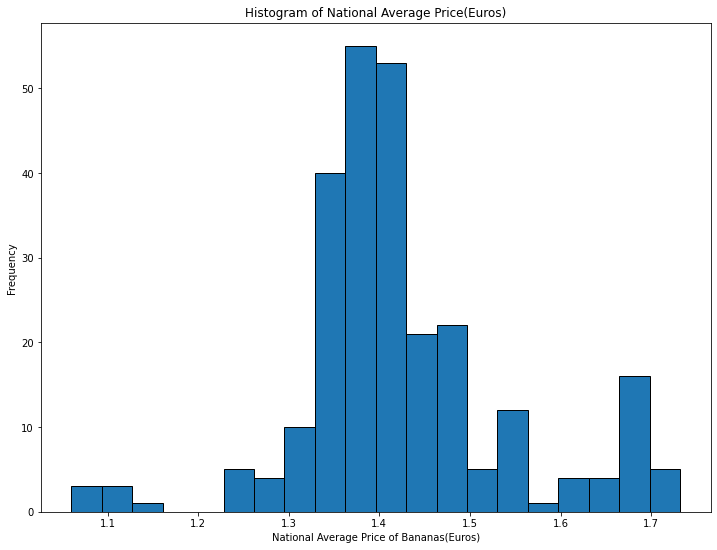

In [54]:
# Plot a Histogram
data_driver = {'obs': merged_df.select('National Average Price(Euros)').rdd.flatMap(lambda row: row).collect()}

# Filter out None values from the data
data_filtered = [x for x in data_driver['obs'] if x is not None]

# Create histogram
plt.figure(figsize=(12, 9))
plt.hist(data_filtered, bins=20, edgecolor='black')
plt.title('Histogram of National Average Price(Euros)')
plt.xlabel('National Average Price of Bananas(Euros)')
plt.ylabel('Frequency')

# Save the histogram as an image
plt.savefig('B05793_05_22.png', dpi=300)
plt.show()

## EXPORT THE PREPROCESSED DATA TO HADOOP FOR STORAGE

In [55]:
# Export preprocessed data
preprocessed_data_path = "hdfs://localhost:9000/preprocessed_data.csv"
merged_df.write.csv(preprocessed_data_path, mode="overwrite", header=True)

# Convert the data to pandas

In [56]:
#Convert the merged_df spark DataFrame to Pandas
banana_price = merged_df.toPandas()

In [57]:
#Check the data type
type(banana_price)

pandas.core.frame.DataFrame

In [58]:
#Check the head of the DataFrame
banana_price.head()

,Consumer Item,date,National Average Price(Euros)
0,Bananas per kg.,2002 January,1.691
1,Bananas per kg.,2002 February,1.670
2,Bananas per kg.,2002 March,1.496
3,Bananas per kg.,2002 April,1.669
4,Bananas per kg.,2002 May,1.623


In [59]:
#Check the characteristics of the DataFrame
banana_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumer Item                  264 non-null    object 
 1   date                           264 non-null    object 
 2   National Average Price(Euros)  264 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.3+ KB


In [60]:
# Save the DataFrame to a CSV file
banana_price.to_csv("/home/hduser/Documents/Advanced-Data-Analytics-and-BIg-Data-Analytics-Project/banana_price.csv", index=False)

# Import the Libraries required

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [62]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Import the banana_price csv as a pandas

In [63]:
#Import the banana_price csv
banana_price = read_csv("banana_price.csv")

In [64]:
#View the first few observations
banana_price.head(2)

,Consumer Item,date,National Average Price(Euros)
0,Bananas per kg.,2002 January,1.691
1,Bananas per kg.,2002 February,1.670


In [65]:
#View the last few observations
banana_price.tail(2)

,Consumer Item,date,National Average Price(Euros)
262,Bananas per kg,2023 November,1.728
263,Bananas per kg,2023 December,1.732


In [66]:
#View the characteristics of the dataset
banana_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumer Item                  264 non-null    object 
 1   date                           264 non-null    object 
 2   National Average Price(Euros)  264 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.3+ KB


In [67]:
#View the statistics of the dataset
banana_price.describe()

,National Average Price(Euros)
count,264.000000
mean,1.422564
std,0.118254
min,1.060000
25%,1.362750
50%,1.401500
75%,1.465250
max,1.732000


In [68]:
import pandas as pd
# Convert 'Date' to datetime format
banana_price['date'] = pd.to_datetime(banana_price['date'], format='%Y %B')

# Data Visualization
- Plot line plot for National Average price vs  Date
- Plot line plot for National Average price vs Month

## Scatter Plot for the Natonal Average Banana Price Vs Date

In [69]:
import plotly.express as px

# Convert 'date' column to datetime
banana_price['date'] = pd.to_datetime(banana_price['date'])

# Plotly Express Scatter Plot with Trend Line
fig = px.scatter(banana_price, x='date', y='National Average Price(Euros)', 
                 title='Scatter Plot of Date vs. National Average Price(Euros) with Trend Line',
                 labels={'National Average Price(Euros)': 'National Average Price(Euros)'},
                 range_y=[0.5, 1.8], trendline="ols")  # Set the y-axis range and add trendline
fig.update_xaxes(title_text='Date')
fig.show()

## Dynamic Line Plot of National average banana price vs date

In [70]:
import plotly.express as px

#Convert 'date' column to datetime
banana_price['date'] = pd.to_datetime(banana_price['date'])

#Extract year and month
banana_price['Year'] = banana_price['date'].dt.year
banana_price['Month'] = banana_price['date'].dt.month

#Plotly Express
fig = px.line(banana_price, x='Month', y='National Average Price(Euros)', animation_frame='Year', range_x=[0, 12])
fig.update_layout(title='Line Plot of National Average Price(Euros) over Months',
                  xaxis_title='Month',
                  yaxis_title='National Average Price(Euros)',
                  yaxis_range=[0.5, 1.8])  
fig.show()
#Save the plot as an HTML file
fig.write_html("banana_price_plot.html")

## Line Plot for National Average banana price vs Date

In [71]:
import plotly.express as px

# Convert 'date' column to datetime
banana_price['date'] = pd.to_datetime(banana_price['date'])

# Plotly Express Line Plot
fig = px.line(banana_price, x='date', y='National Average Price(Euros)', 
              title='Line Plot of Date vs. National Average Price(Euros)',
              labels={'National Average Price(Euros)': 'National Average Price(Euros)'})

# Update x-axis title
fig.update_xaxes(title_text='Date')

# Show the plot
fig.show()

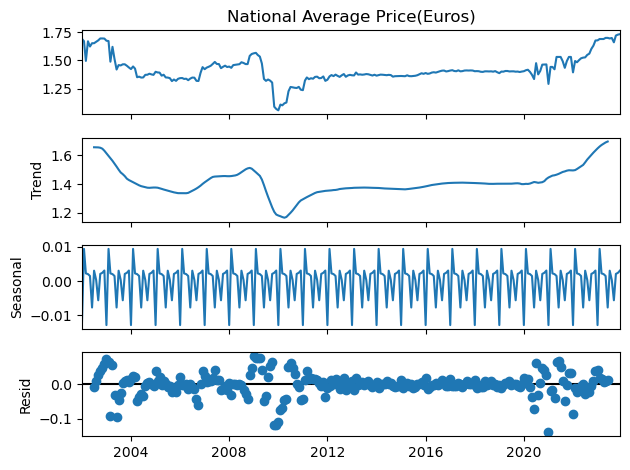

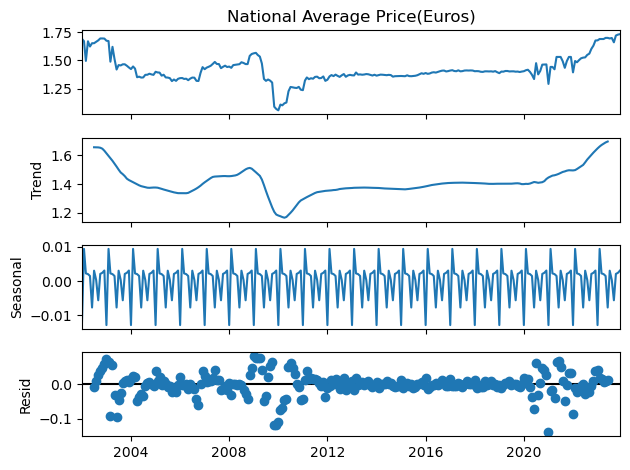

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = banana_price.set_index('date')
results = seasonal_decompose(df['National Average Price(Euros)'])
results.plot()

# STATISTICS

## Normality Test
Kolmogrov Sminorv was used because the observations were more than 30

## Kolmogorov-Sminorv Test

In [73]:
from scipy.stats import kstest

#Extract the 'price_variable' column from the dataset
national_price = banana_price['National Average Price(Euros)']

#Perform Kolmogorov-Smirnov test for normality
statistic, p_value = kstest(national_price, 'norm')

#Print the results
print("Kolmogorov-Smirnov Test Statistic:", statistic)
print("p-value:", p_value)

#Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject H0: which states that data are taken from normal distributed population and accept H1:which states that data are not taken from normal distributed population ")
else:
    print("Accept H0: which states that data are taken from normal distributed population and reject H1: which states that data are not taken from normal distributed population ")

Kolmogorov-Smirnov Test Statistic: 0.8637613644958709
p-value: 1.4644995238989183e-228
Reject H0: which states that data are taken from normal distributed population and accept H1:which states that data are not taken from normal distributed population 


## Findings
- The data is not taken from a normally distributed population, i.e data is not normally distributed.

# LSTM FOR BANANA PRICES

In [74]:
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('banana_price.csv', usecols=[2])

In [75]:
#View the first few observations of the dataframe
dataframe.head(3)

,National Average Price(Euros)
0,1.691
1,1.670
2,1.496


In [76]:
#Check the characteristics of the dataframe
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 1 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   National Average Price(Euros)  264 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [77]:
#Get the values of the dataframe (excluding any index or column labels)
dataset = dataframe.values

# Convert the data type of the dataset to float32
dataset = dataset.astype('float32')

## Normalize the Data Using MinMax Scaler

In [78]:
#Normalize the dataset using the MinMax Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Split the Data into Test and Train set

In [79]:
#Exclude the last 12 observations for training
train_size = len(dataset) - 12 

#Last 12 observations for testing
test_size = 12  

train = dataset[:-12]  # Exclude the last 12 observations
test = dataset[-12:] 

In [80]:
#View the shape of the train and test dataset
train.shape, test.shape

((252, 1), (12, 1))

In [81]:
#Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [82]:
#Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [83]:
#View the shape of trainX and testx
trainX.shape, testX.shape

((250, 1, 1), (10, 1, 1))

# CREATE AND TRAIN THE LSTM MODEL

In [84]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
250/250 - 2s - loss: 0.0313 - 2s/epoch - 7ms/step
Epoch 2/100
250/250 - 0s - loss: 0.0071 - 277ms/epoch - 1ms/step
Epoch 3/100
250/250 - 0s - loss: 0.0061 - 309ms/epoch - 1ms/step
Epoch 4/100
250/250 - 0s - loss: 0.0054 - 339ms/epoch - 1ms/step
Epoch 5/100
250/250 - 0s - loss: 0.0047 - 335ms/epoch - 1ms/step
Epoch 6/100
250/250 - 0s - loss: 0.0042 - 296ms/epoch - 1ms/step
Epoch 7/100
250/250 - 0s - loss: 0.0040 - 327ms/epoch - 1ms/step
Epoch 8/100
250/250 - 0s - loss: 0.0038 - 333ms/epoch - 1ms/step
Epoch 9/100
250/250 - 0s - loss: 0.0037 - 326ms/epoch - 1ms/step
Epoch 10/100
250/250 - 0s - loss: 0.0037 - 272ms/epoch - 1ms/step
Epoch 11/100
250/250 - 0s - loss: 0.0036 - 327ms/epoch - 1ms/step
Epoch 12/100
250/250 - 0s - loss: 0.0036 - 332ms/epoch - 1ms/step
Epoch 13/100
250/250 - 0s - loss: 0.0036 - 302ms/epoch - 1ms/step
Epoch 14/100
250/250 - 0s - loss: 0.0037 - 308ms/epoch - 1ms/step
Epoch 15/100
250/250 - 0s - loss: 0.0036 - 298ms/epoch - 1ms/step
Epoch 16/100
250/250 -

In [85]:
#Make predictions for the trainX and testX
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 15ms/step


In [86]:
trainPredict.shape, testPredict.shape

((250, 1), (10, 1))

In [87]:
#Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Evaluate the Model Performance using the following metrics
- MSE
- MAE

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate mean squared error
trainScore_mse = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore_mse))
testScore_mse = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore_mse))


# Calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore_mae))
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore_mae))

Train Score: 0.00 MSE
Test Score: 0.00 MSE
Train Score: 0.02 MAE
Test Score: 0.03 MAE


In [89]:
# Create a DataFrame to store actual and predicted values
comparison_table = pd.DataFrame({'Actual': testY[0], 'Predicted': testPredict[:,0]})

# Print the comparison table
print(comparison_table)

   Actual  Predicted
0   1.689   1.652885
1   1.689   1.662608
2   1.689   1.662608
3   1.699   1.662608
4   1.699   1.670642
5   1.694   1.670642
6   1.698   1.666633
7   1.660   1.669841
8   1.720   1.638959
9   1.728   1.687307


In [90]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


In [91]:
#shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


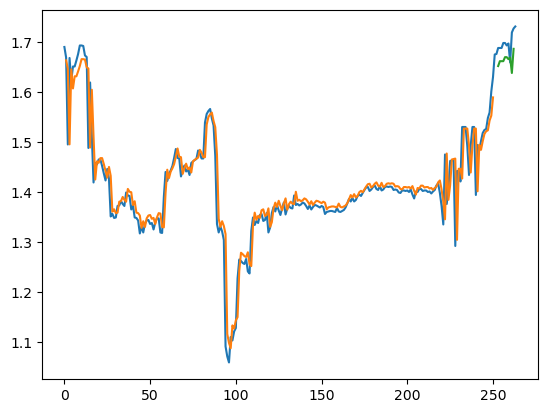

In [92]:
#plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Standardize the data using standard scaler

In [93]:
#Use the dataset again 
dataset = dataframe.values
dataset = dataset.astype('float32')

In [94]:
#Normalize the dataset using the StandardScaler
from sklearn.preprocessing import StandardScaler

#Initialize the StandardScaler
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

# split the data into train and test

#split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [95]:
#Exclude the last 12 observations for training
train_size = len(dataset) - 12 

#Last 12 observations for testing
test_size = 12  

train = dataset[:-12]  # Exclude the last 12 observations
test = dataset[-12:] 

In [96]:
#View the train and test Shape
train.shape, test.shape

((252, 1), (12, 1))

In [97]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [98]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## TRAIN THE LSTM MODEL USING STANDARDIZED DATA

In [99]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
250/250 - 2s - loss: 0.6532 - 2s/epoch - 8ms/step
Epoch 2/100
250/250 - 0s - loss: 0.5288 - 277ms/epoch - 1ms/step
Epoch 3/100
250/250 - 0s - loss: 0.4073 - 291ms/epoch - 1ms/step
Epoch 4/100
250/250 - 0s - loss: 0.3085 - 319ms/epoch - 1ms/step
Epoch 5/100
250/250 - 0s - loss: 0.2366 - 316ms/epoch - 1ms/step
Epoch 6/100
250/250 - 0s - loss: 0.1948 - 310ms/epoch - 1ms/step
Epoch 7/100
250/250 - 0s - loss: 0.1724 - 343ms/epoch - 1ms/step
Epoch 8/100
250/250 - 0s - loss: 0.1619 - 351ms/epoch - 1ms/step
Epoch 9/100
250/250 - 0s - loss: 0.1557 - 366ms/epoch - 1ms/step
Epoch 10/100
250/250 - 0s - loss: 0.1521 - 343ms/epoch - 1ms/step
Epoch 11/100
250/250 - 0s - loss: 0.1487 - 315ms/epoch - 1ms/step
Epoch 12/100
250/250 - 0s - loss: 0.1459 - 377ms/epoch - 2ms/step
Epoch 13/100
250/250 - 0s - loss: 0.1437 - 317ms/epoch - 1ms/step
Epoch 14/100
250/250 - 0s - loss: 0.1418 - 304ms/epoch - 1ms/step
Epoch 15/100
250/250 - 0s - loss: 0.1399 - 304ms/epoch - 1ms/step
Epoch 16/100
250/250 -

In [100]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 15ms/step


In [101]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate mean squared error
trainScore_mse = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore_mse))
testScore_mse = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore_mse))

# Calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore_mae))
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore_mae))


Train Score: 0.00 MSE
Test Score: 0.00 MSE
Train Score: 0.02 MAE
Test Score: 0.06 MAE


In [103]:
# Create a DataFrame to store actual and predicted values
comparison_table = pd.DataFrame({'Actual': testY[0], 'Predicted': testPredict[:,0]})

# Print the comparison table
print(comparison_table)

   Actual  Predicted
0   1.689   1.632803
1   1.689   1.639035
2   1.689   1.639035
3   1.699   1.639035
4   1.699   1.643977
5   1.694   1.643977
6   1.698   1.641534
7   1.660   1.643493
8   1.720   1.623398
9   1.728   1.653626


In [104]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [105]:
#shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

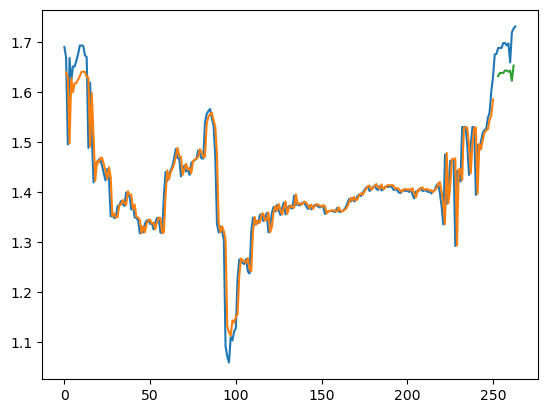

In [106]:
#plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Using Robust Scaler because it can handle outliers

In [107]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [108]:
#Scale the data using RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

# Split the data into train and test data

In [109]:
#Exclude the last 12 observations for training
train_size = len(dataset) - 12 

#Last 12 observations for testing
test_size = 12  

train = dataset[:-12]  # Exclude the last 12 observations
test = dataset[-12:] 

In [110]:
#View the test and train shape
train.shape, test.shape

((252, 1), (12, 1))

In [111]:
#Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [112]:
#Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# TRAIN THE LSTM MODEL USING ROBUSTSCALER

In [113]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
250/250 - 2s - loss: 0.6398 - 2s/epoch - 7ms/step
Epoch 2/100
250/250 - 0s - loss: 0.5041 - 311ms/epoch - 1ms/step
Epoch 3/100
250/250 - 0s - loss: 0.3863 - 288ms/epoch - 1ms/step
Epoch 4/100
250/250 - 0s - loss: 0.3083 - 277ms/epoch - 1ms/step
Epoch 5/100
250/250 - 0s - loss: 0.2642 - 289ms/epoch - 1ms/step
Epoch 6/100
250/250 - 0s - loss: 0.2436 - 280ms/epoch - 1ms/step
Epoch 7/100
250/250 - 0s - loss: 0.2317 - 269ms/epoch - 1ms/step
Epoch 8/100
250/250 - 0s - loss: 0.2246 - 275ms/epoch - 1ms/step
Epoch 9/100
250/250 - 0s - loss: 0.2180 - 276ms/epoch - 1ms/step
Epoch 10/100
250/250 - 0s - loss: 0.2133 - 284ms/epoch - 1ms/step
Epoch 11/100
250/250 - 0s - loss: 0.2085 - 268ms/epoch - 1ms/step
Epoch 12/100
250/250 - 0s - loss: 0.2042 - 314ms/epoch - 1ms/step
Epoch 13/100
250/250 - 0s - loss: 0.2007 - 342ms/epoch - 1ms/step
Epoch 14/100
250/250 - 0s - loss: 0.1976 - 323ms/epoch - 1ms/step
Epoch 15/100
250/250 - 0s - loss: 0.1948 - 328ms/epoch - 1ms/step
Epoch 16/100
250/250 -

In [114]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 16ms/step


In [115]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate mean squared error
trainScore_mse = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore_mse))
testScore_mse = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore_mse))

# Calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore_mae))
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore_mae))


Train Score: 0.00 MSE
Test Score: 0.00 MSE
Train Score: 0.02 MAE
Test Score: 0.05 MAE


In [117]:
# Create a DataFrame to store actual and predicted values
comparison_table = pd.DataFrame({'Actual': testY[0], 'Predicted': testPredict[:,0]})

# Print the comparison table
print(comparison_table)

   Actual  Predicted
0   1.689   1.639696
1   1.689   1.645864
2   1.689   1.645864
3   1.699   1.645864
4   1.699   1.650647
5   1.694   1.650647
6   1.698   1.648296
7   1.660   1.650183
8   1.720   1.630125
9   1.728   1.659685


In [118]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [119]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


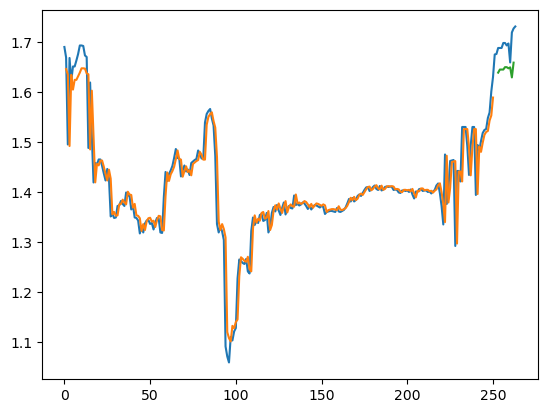

In [120]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()